##### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##### Uploading the dataset

In [ ]:
df = pd.read_csv("C:/Users/Puni/Desktop/daily-minimum-temperatures-in-me.csv")
df

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8
...,...,...
3645,12/27/1990,14
3646,12/28/1990,13.6
3647,12/29/1990,13.5
3648,12/30/1990,15.7


## Task-1 Exploratory Data Analysis (EDA)

#### Summary Statistics(mean, median and standard deviation)
#### Time Series plots to visualize trends and seasonaility
#### Correlation heatmaps to identify relationship between variables
#### Seasional decomposition to detect patterns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [ ]:
## Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## Clean Temperature column by removing non-numeric characters and converting the data to numeric
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'].astype(str).str.replace("[^0-9\.-]", "", regex = True), errors = "coerce")

## Drop any rows where temperature cannot be converted
df.dropna(subset=["Daily minimum temperatures"], inplace=True)

In [ ]:
df.describe()

,Daily minimum temperatures
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


##### So here Mean = 11.17°C, Median = 11.0°C and Standard deviation = 4.0°C

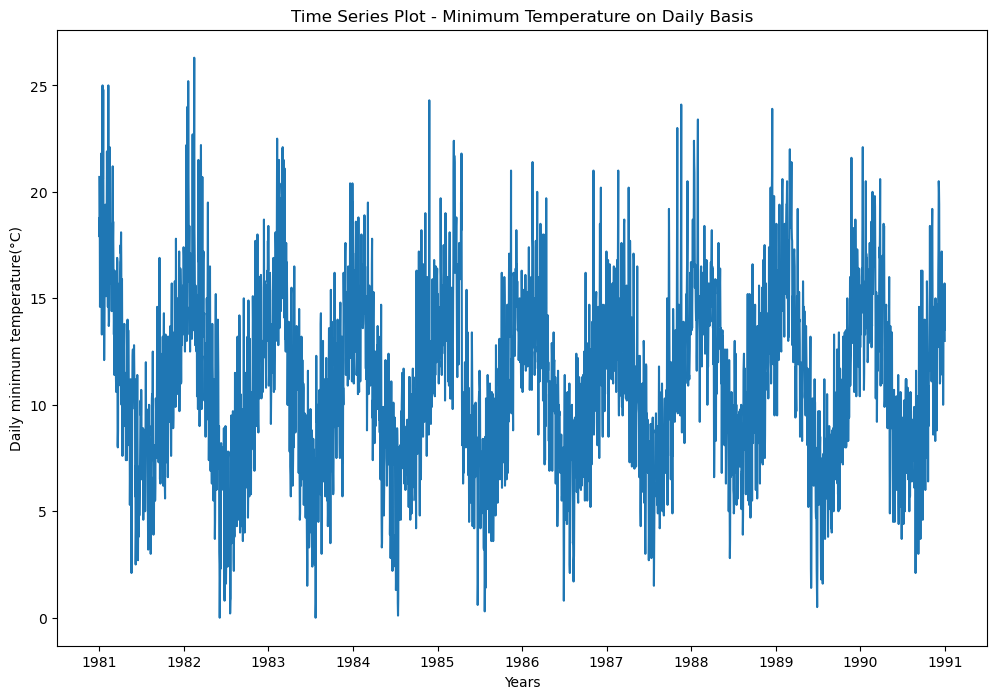

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df.index, df["Daily minimum temperatures"])
plt.title("Time Series Plot - Minimum Temperature on Daily Basis")
plt.xlabel("Years")
plt.ylabel("Daily minimum temperature(°C)")
plt.show()

##### To find out the correlation we require more features hence adding year, month, quarter and day of the week columns

In [ ]:
df.index = pd.to_datetime(df.index, errors='coerce')
df["Year"] = df.index.year
df["Quarter"] = df.index.quarter
df["Month"] = df.index.month
df["DayofWeek"] = df.index.dayofweek
df["Day"] = df.index.day

In [ ]:
df.head()

,Daily minimum temperatures,Year,Quarter,Month,DayofWeek,Day
Date,,,,,,
1981-01-01,20.7,1981,1,1,3,1
1981-01-02,17.9,1981,1,1,4,2
1981-01-03,18.8,1981,1,1,5,3
1981-01-04,14.6,1981,1,1,6,4
1981-01-05,15.8,1981,1,1,0,5


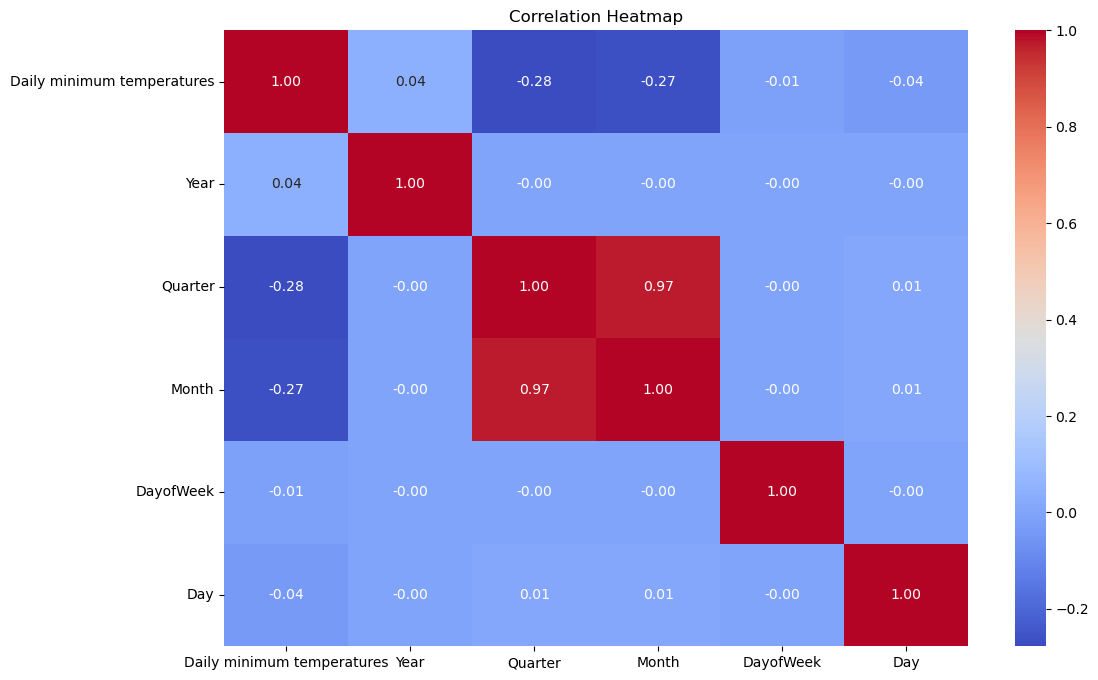

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap")
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

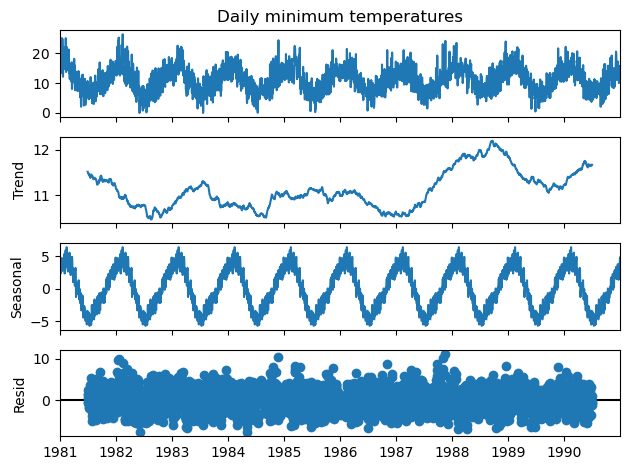

In [ ]:
## For Seasonal Decomposition, consider 365 to get daily data with yearly seasonality

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Daily minimum temperatures'], model='additive', period=365)
result.plot()
plt.show()

## Task-2 Data Processing and Feature Engineering

#### Handling missing values using forward fill and interpolation
#### Outliers detection using IQR and Z-Score methods
#### Time-Based Features created: Day of week, Month, Season and Lag features
#### Correlation analysis - Pearson Correlation matrix
#### Normalisation using Standard Scaler

#### As we already have month and day of the week features, now we need season and lag features for Time based analysis

In [ ]:
## Creating seasons using month column: Winter=0, Spring=1, Summer=2 and Autumn=3
df["Season"] = df["Month"] %12//3

## Creating Lag features like previous day's temperature using Daily minimum temperatures column
df["Lag1"] = df["Daily minimum temperatures"].shift(1)
df["Lag2"] = df["Daily minimum temperatures"].shift(2)

In [ ]:
df.head()

,Daily minimum temperatures,Year,Quarter,Month,DayofWeek,Day,Season,Lag1,Lag2
Date,,,,,,,,,
1981-01-01,20.7,1981,1,1,3,1,0,NaN,NaN
1981-01-02,17.9,1981,1,1,4,2,0,20.7,NaN
1981-01-03,18.8,1981,1,1,5,3,0,17.9,20.7
1981-01-04,14.6,1981,1,1,6,4,0,18.8,17.9
1981-01-05,15.8,1981,1,1,0,5,0,14.6,18.8


In [ ]:
lag_cols = [col for col in df.columns if "Lag" in col]
df = df.dropna(subset=lag_cols).copy()
df.head()

,Daily minimum temperatures,Year,Quarter,Month,DayofWeek,Day,Season,Lag1,Lag2
Date,,,,,,,,,
1981-01-01,20.7,1981,1,1,3,1,0,20.7,20.7
1981-01-02,17.9,1981,1,1,4,2,0,20.7,20.7
1981-01-03,18.8,1981,1,1,5,3,0,17.9,20.7
1981-01-04,14.6,1981,1,1,6,4,0,18.8,17.9
1981-01-05,15.8,1981,1,1,0,5,0,14.6,18.8


In [ ]:
df.isnull().sum()

Daily minimum temperatures    0
Year                          0
Quarter                       0
Month                         0
DayofWeek                     0
Day                           0
dtype: int64

In [ ]:
## Funtion to remove outliers using IQR method column wise

def remove_outliers(df, columns):
         
         for col in columns:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            before_count = df.shape[0]
            df = df[(df[col] >= lower_bound) & (df[col]<= upper_bound)]
            after_count = df.shape[0]

## Print how many outliers were removed per column
            print(f"Outliers removed from {col}: {before_count - after_count}")

         return df

numerical_columns = ['Daily minimum temperatures', 'Year', 'Quarter','Month', 'DayofWeek', 'Day']

df_no_outlier = remove_outliers(df, numerical_columns)

## Print dataset shape before and after outlier removal
print("Original shape:", df.shape)
print("After removing Outliers:", df_no_outlier.shape)

Outliers removed from Daily minimum temperatures: 13
Outliers removed from Year: 0
Outliers removed from Quarter: 0
Outliers removed from Month: 0
Outliers removed from DayofWeek: 0
Outliers removed from Day: 0
Original shape: (3650, 6)
After removing Outliers: (3637, 6)


In [ ]:
## Function to remove outliers using Z-score method for Daily minimum temperatures column as only it has outliers as per result of IQR method above

## Converting the Temperature column to numeric
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors ='coerce')
def remove_outliers_zscore(df, col='Daily minimum temperatures', threshold=3.0):
    
        ## compute mean and standard deviation
        mean = df[col].mean()
        std = df[col].std()

        ## compute Z-scores
        z_scores = (df[col] - mean)/std

        before_count = df.shape[0]
        df = df[np.abs(z_scores) <= threshold]
        after_count = df.shape[0]

        ## Print how many outliers removed per column
        print(f"Outliers removed from {col}: {before_count - after_count}")
        return df

## Apply function
df_no_outlier_z = remove_outliers_zscore(df, col='Daily minimum temperatures', threshold = 3.0)

## Print temperature column shape before and after outlier removal
print("Original shape:", df.shape)
print("After removing Outliers:", df_no_outlier_z.shape)

Outliers removed from Daily minimum temperatures: 10
Original shape: (3650, 6)
After removing Outliers: (3640, 6)


#### By this we can see that IQR method has removed more outliers than Z-score method

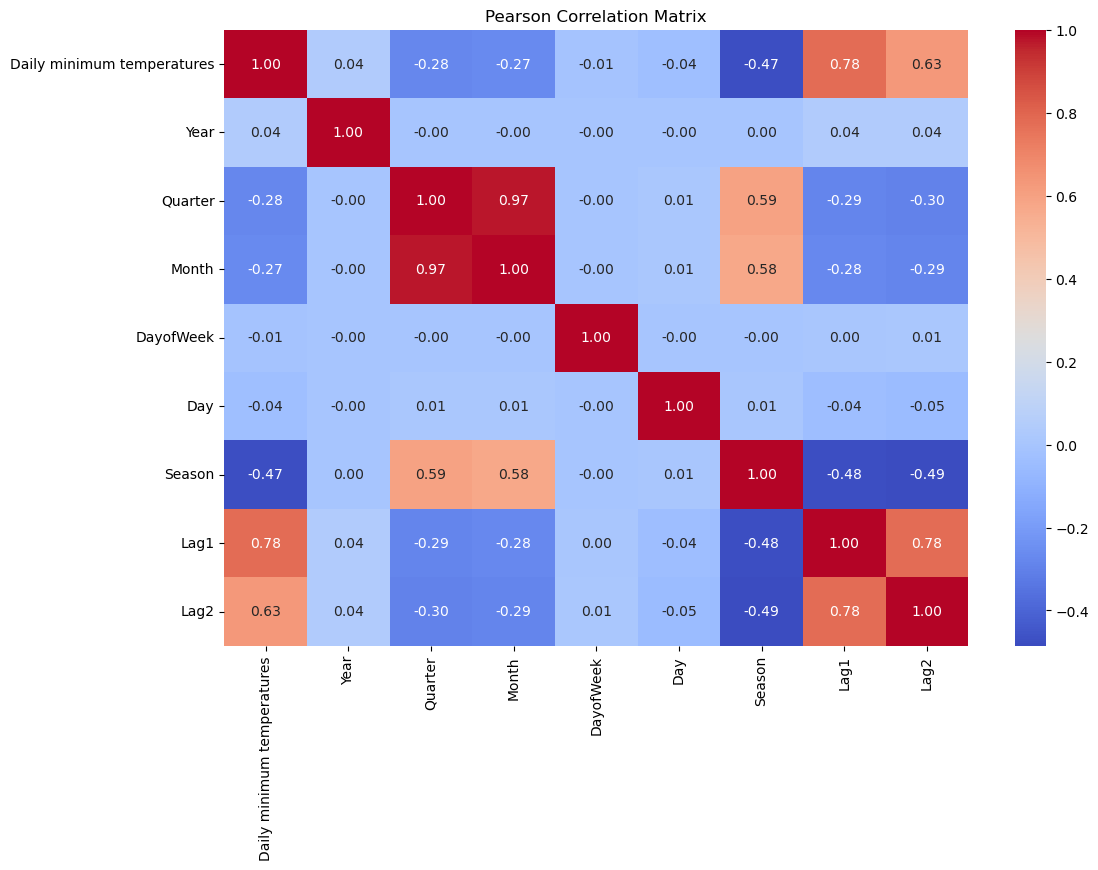

In [ ]:
## Correlation Analysis: Pearson correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson Correlation Matrix")
plt.show()

In [ ]:
## Normalisation using Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

## Create a scaled dataframe with same columns so that it can be used for Linear regression model as it is sensitive to features with different scales
df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
print(df_scaled.head())

            Daily minimum temperatures      Year   Quarter     Month  \
Date                                                                   
1981-01-01                    2.338883 -1.566699 -1.350262 -1.601508   
1981-01-02                    1.651139 -1.566699 -1.350262 -1.601508   
1981-01-03                    1.872199 -1.566699 -1.350262 -1.601508   
1981-01-04                    0.840583 -1.566699 -1.350262 -1.601508   
1981-01-05                    1.135330 -1.566699 -1.350262 -1.601508   

            DayofWeek       Day    Season      Lag1      Lag2  
Date                                                           
1981-01-01  -0.000548 -1.673717 -1.349771  2.336679  2.334991  
1981-01-02   0.499486 -1.560009 -1.349771  2.336679  2.334991  
1981-01-03   0.999521 -1.446302 -1.349771  1.649430  2.334991  
1981-01-04   1.499555 -1.332594 -1.349771  1.870332  1.648140  
1981-01-05  -1.500651 -1.218886 -1.349771  0.839459  1.868913  


## Task-3 Regression model development and evaluation
#### Models Implemented: Linear Regression and Random Forest
#### Data Splitting: Training set-70%, Validation set-15% and Test set-15%
#### Evaluation Metrics: Mean Squared Error(MSE), Mean Absolute Error(MAE), R-Squared Error(R²)
#### Feature Importance, Hyper Tuning(using GridSearchCV on validation set) and Final Results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Feature Selection
X = df_scaled.drop(columns=["Daily minimum temperatures"])
y = df_scaled[["Daily minimum temperatures"]]

## First Split: Train + Temp where Temp = Test + Validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
## Second Split: Splitting Temp into Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
## here we gave test size as 0.5 because we already have test size as 0.3 whcih is 30% and now we need to split it equally to get 15% for val and 15% for test

## Intialize and train the model
model1 = LinearRegression()
model1.fit(X_train, y_train)

## Prediction
y_val_pred_LR = model1.predict(X_val)

print("Linear Regression (Validation)")
print("MSE:", mean_squared_error(y_val, y_val_pred_LR))
print("MAE:", mean_absolute_error(y_val, y_val_pred_LR))
print("R²:", r2_score(y_val, y_val_pred_LR))

Linear Regression (Validation)
MSE: 0.35422920575001765
MAE: 0.4668345951365266
R²: 0.6516923301733528


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Random Forest model with Hyper parameter Tuning - GridSearchCV used on validation set
model2 = RandomForestRegressor(random_state = 42)

param_grid = {
    "n_estimators" : [100, 200, 500],
    "max_depth" : [None, 5, 10, 20],
    "min_samples_split" : [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ['sqrt', 'log2']
}

grid_search = GridSearchCV(model2, param_grid, cv =5, scoring = 'r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model2 = grid_search.best_estimator_

## Prediction
y_val_pred_RF = best_model2.predict(X_val)

print("Random Forest (Validation)")
print("MSE:", mean_squared_error(y_val, y_val_pred_RF))
print("MAE:", mean_absolute_error(y_val, y_val_pred_RF))
print("R²:", r2_score(y_val, y_val_pred_RF))

Random Forest (Validation)
MSE: 0.31301096202515816
MAE: 0.43955158116998766
R²: 0.6922215417491037


### Final Evaluation on test set for both Linear Regression and Random Forest models

In [ ]:
y_test_pred_LR = model1.predict(X_test)
y_test_pred_RF = best_model2.predict(X_test)

print("Results of Linear Regression and Random forest models on Test set")
print("Linear Regression (Test set)")
print("MSE:", mean_squared_error(y_test, y_test_pred_LR))
print("MAE:", mean_absolute_error(y_test, y_test_pred_LR))
print("R²:", r2_score(y_test, y_test_pred_LR))

print("Random Forest (Test set)")
print("MSE:", mean_squared_error(y_test, y_test_pred_RF))
print("MAE:", mean_absolute_error(y_test, y_test_pred_RF))
print("R²:", r2_score(y_test, y_test_pred_RF))

Results of Linear Regression and Random forest models on Test set
Linear Regression (Test set)
MSE: 0.39457870859802335
MAE: 0.4877574894649528
R²: 0.61489464884918
Random Forest (Test set)
MSE: 0.34233155938293447
MAE: 0.461774184834454
R²: 0.665887407218218


### As per the above results, Random Forest model clearly ouperformed Linear Regression in all metrics.

#### In another way, Both model performance is tested using ROC Curve where both regression models are treated as classifiers

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

threshold = y_train.median().values[0]
y_val_class = (y_val.values.ravel() > threshold).astype(int)

# ROC curve for Linear Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val_class, y_val_pred_LR)
auc_lr = roc_auc_score(y_val_class, y_val_pred_LR)

# ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val_class, y_val_pred_RF)
auc_rf = roc_auc_score(y_val_class, y_val_pred_RF)

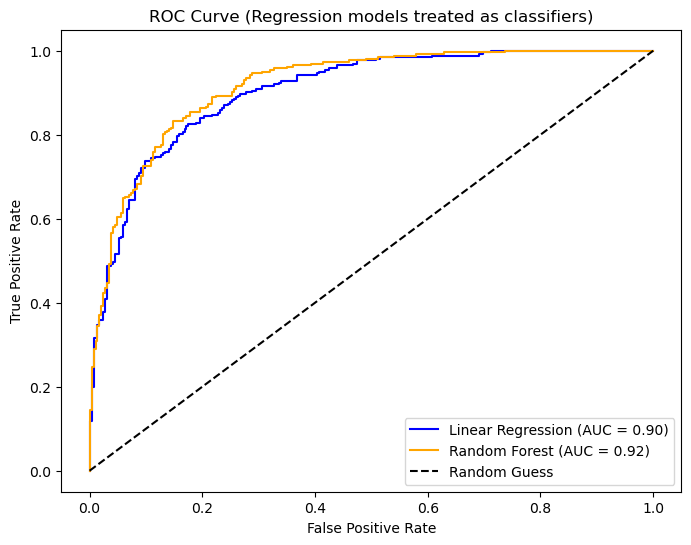

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Linear Regression (AUC = {auc_lr:.2f})", color="blue")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color="orange")
plt.plot([0,1],[0,1],'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Regression models treated as classifiers)")
plt.legend()
plt.show()

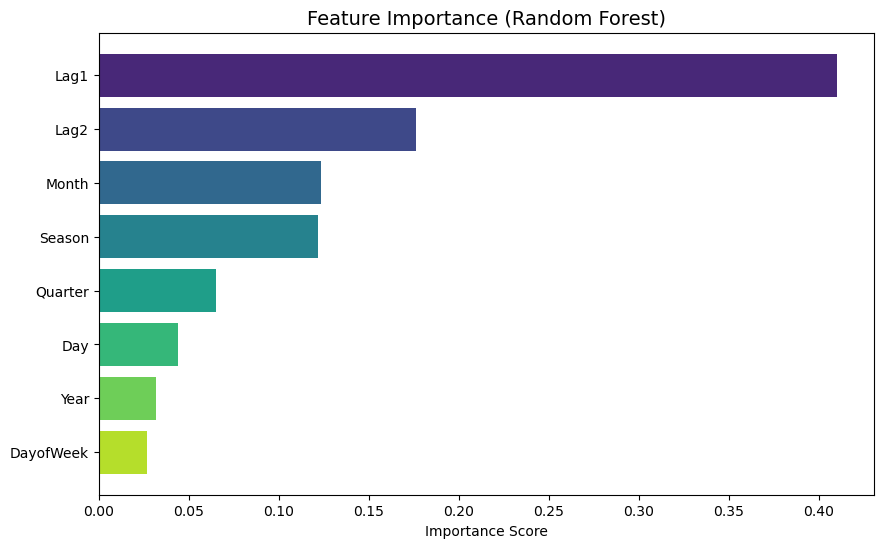

In [ ]:
## Feature Importance

# Get feature importances from the trained Random Forest
importances = best_model2.feature_importances_
features = X_train.columns

# Put into a DataFrame for easy handling
feat_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

# Pick a nice color palette
colors = sns.color_palette("viridis", len(feat_importances))

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_importances["Feature"], feat_importances["Importance"], 
         color=colors)
plt.gca().invert_yaxis()  # most important at top
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.show()

### Now we can see that Lag and Temperature are the most influential variables

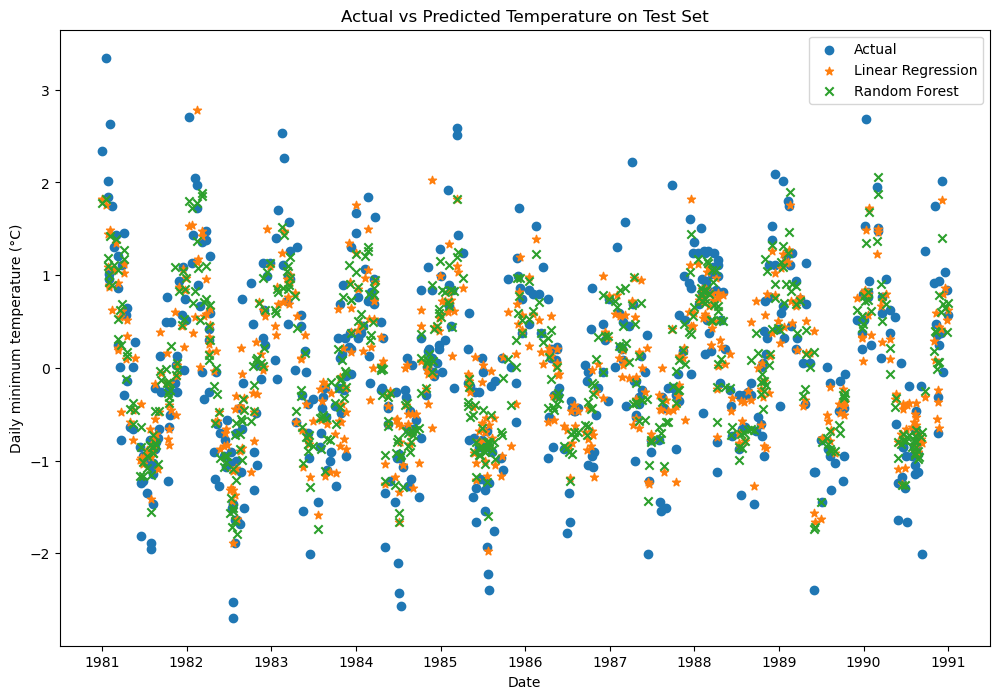

In [ ]:
## Compare predictions vs actual on test set

plt.figure(figsize=(12,8))
plt.scatter(y_test.index, y_test, label="Actual", marker='o')
plt.scatter(y_test.index, y_test_pred_LR, label='Linear Regression', marker='*')
plt.scatter(y_test.index, y_test_pred_RF, label='Random Forest', marker='x')
plt.title("Actual vs Predicted Temperature on Test Set")
plt.xlabel("Date")
plt.ylabel("Daily minimum temperature (°C)")
plt.legend()
plt.show()

### As per above Predictions on test set showed good alignment with the actual values